<a href="https://colab.research.google.com/github/chitvan101/Crime_Analysis/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [ ]:
!pip3 uninstall pyspark
!pip3 install pyspark==3.0.2

Found existing installation: pyspark 3.0.2
Uninstalling pyspark-3.0.2:
  Would remove:
    /usr/local/bin/beeline
    /usr/local/bin/beeline.cmd
    /usr/local/bin/docker-image-tool.sh
    /usr/local/bin/find-spark-home
    /usr/local/bin/find-spark-home.cmd
    /usr/local/bin/find_spark_home.py
    /usr/local/bin/load-spark-env.cmd
    /usr/local/bin/load-spark-env.sh
    /usr/local/bin/pyspark
    /usr/local/bin/pyspark.cmd
    /usr/local/bin/pyspark2.cmd
    /usr/local/bin/run-example
    /usr/local/bin/run-example.cmd
    /usr/local/bin/spark-class
    /usr/local/bin/spark-class.cmd
    /usr/local/bin/spark-class2.cmd
    /usr/local/bin/spark-shell
    /usr/local/bin/spark-shell.cmd
    /usr/local/bin/spark-shell2.cmd
    /usr/local/bin/spark-sql
    /usr/local/bin/spark-sql.cmd
    /usr/local/bin/spark-sql2.cmd
    /usr/local/bin/spark-submit
    /usr/local/bin/spark-submit.cmd
    /usr/local/bin/spark-submit2.cmd
    /usr/local/bin/sparkR
    /usr/local/bin/sparkR.cmd
    /usr/lo

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "8g")\
.config("spark.driver.cores", "3")\
.getOrCreate()

In [ ]:
crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset =spark.read.option("header", "True")\
        .option("inferSchema", "true").csv("/content/drive/MyDrive/Book1.csv")

In [ ]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09-05-2015 13:30,043XX S WOOD ST,486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12,61,08B,1165074.0,1875917.0,2015,02-10-2018 15:50,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09-04-2015 11:30,008XX N CENTRAL AVE,870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29,25,6,1138875.0,1904869.0,2015,02-10-2018 15:50,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09-01-2018 00:01,082XX S INGLESIDE AVE,810,THEFT,OVER $500,RESIDENCE,False,True,...,8,44,6,NaN,NaN,2018,04-06-2019 16:04,NaN,NaN,None
3,10224740,HY411595,09-05-2015 12:45,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35,21,18,1152037.0,1920384.0,2015,02-10-2018 15:50,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09-05-2015 13:00,0000X N LARAMIE AVE,560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28,25,08A,1141706.0,1900086.0,2015,02-10-2018 15:50,41.881903,-87.755121,"(41.881903443, -87.755121152)"


In [ ]:
dataset=dataset.filter((dataset['Year'] >2009) & (dataset['Year'] !=2022))
dataset=dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

In [ ]:
dataset=dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset=dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset=dataset.withColumn("Month", F.month(dataset.Day))
dataset=dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset=dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset=dataset.na.drop()
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Day,Month,WeekDay,Hour
0,10224788,HY410899,03/27/2014 12:01:00 AM,035XX S MICHIGAN AVE,5111,OTHER OFFENSE,GUN OFFENDER: ANNUAL REGISTRATION,POLICE FACILITY/VEH PARKING LOT,True,False,...,1881665,2014,02-10-2018 15:50,41.830612,-87.623247,"(41.830611847, -87.623247369)",2014-03-27,3,5,12
1,10224813,HY411765,08/30/2015 04:00:00 PM,014XX S MICHIGAN AVE,820,THEFT,$500 AND UNDER,RESIDENCE-GARAGE,False,False,...,1893551,2015,02-10-2018 15:50,41.863235,-87.624061,"(41.863235129, -87.624061274)",2015-08-30,8,1,4
2,10224837,HY411330,08/25/2015 12:00:00 PM,065XX N MAPLEWOOD AVE,810,THEFT,OVER $500,STREET,False,False,...,1943359,2015,02-10-2018 15:50,42.000328,-87.693615,"(42.000327844, -87.693615326)",2015-08-25,8,3,12
3,12014684,JD189901,03/17/2020 09:30:00 PM,039XX N LECLAIRE AVE,820,THEFT,$500 AND UNDER,STREET,False,False,...,1925649,2020,03/25/2020 03:45:43 PM,41.952052,-87.754660,"(41.952051946, -87.754660372)",2020-03-17,3,3,9
4,10224873,HY411486,08/17/2015 12:00:00 PM,014XX W BARRY AVE,820,THEFT,$500 AND UNDER,STREET,False,False,...,1920679,2015,02-10-2018 15:50,41.937926,-87.664880,"(41.937925583, -87.664880228)",2015-08-17,8,2,12


In [ ]:
dataset.groupby('Primary Type').count().show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|OFFENSE INVOLVING...|  457|
|CRIMINAL SEXUAL A...|    7|
|PUBLIC PEACE VIOL...|  547|
|               ARSON|  119|
|   CRIMINAL TRESPASS| 1489|
|             ASSAULT| 4113|
| MOTOR VEHICLE THEFT| 2523|
|               THEFT|14264|
|             BATTERY|11921|
|             ROBBERY| 2642|
|            HOMICIDE|    2|
| CRIM SEXUAL ASSAULT|  294|
|        PROSTITUTION|  286|
|  DECEPTIVE PRACTICE| 3410|
|         SEX OFFENSE|  222|
|     CRIMINAL DAMAGE| 7445|
|           NARCOTICS| 4810|
|       OTHER OFFENSE| 4088|
|          KIDNAPPING|   45|
|            BURGLARY| 3500|
+--------------------+-----+
only showing top 20 rows



In [ ]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

In [ ]:
dataset.groupby('Primary Type').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|               THEFT|14264|
|             BATTERY|11921|
|     CRIMINAL DAMAGE| 7445|
|           NARCOTICS| 4810|
|             ASSAULT| 4113|
|       OTHER OFFENSE| 4088|
|            BURGLARY| 3500|
|  DECEPTIVE PRACTICE| 3410|
|             ROBBERY| 2642|
| MOTOR VEHICLE THEFT| 2523|
|PUBLIC PEACE VIOL...| 1756|
|   CRIMINAL TRESPASS| 1608|
|         SEX OFFENSE|  802|
|OFFENSE INVOLVING...|  457|
|          KIDNAPPING|   45|
|CRIMINAL SEXUAL A...|    7|
|            HOMICIDE|    2|
+--------------------+-----+



In [ ]:
dataset=dataset.na.drop()

Text(0, 0.5, 'Crime Type')

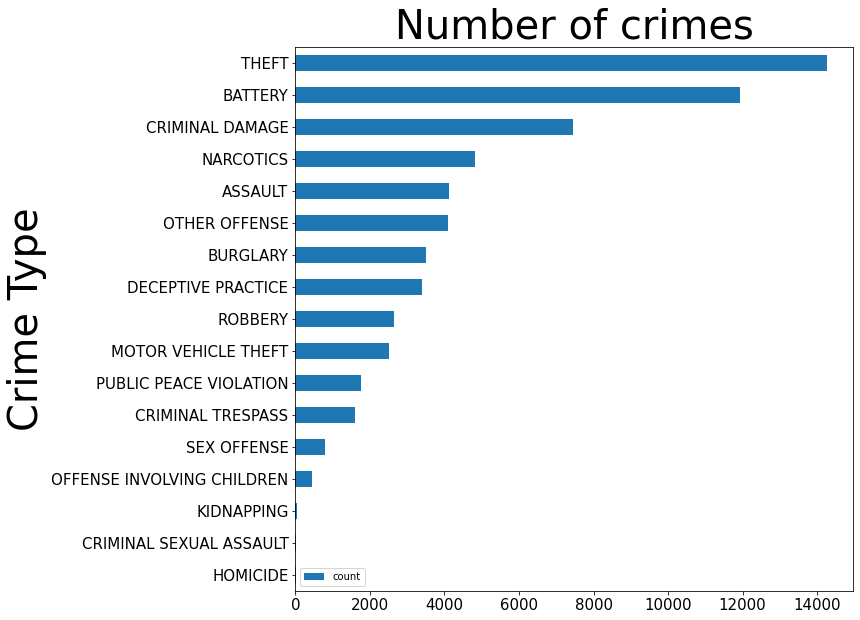

In [ ]:
dataset.groupBy("Primary Type")\
        .count().toPandas().sort_values(by='count')\
        .plot(x='Primary Type',y='count',\
                      sort_columns=True,kind='barh', \
                      figsize=(10, 10),fontsize=15)
plt.title("Number of crimes", fontsize=40)
plt.ylabel('Crime Type', fontsize=40)

Text(0.5, 0, 'Block Name')

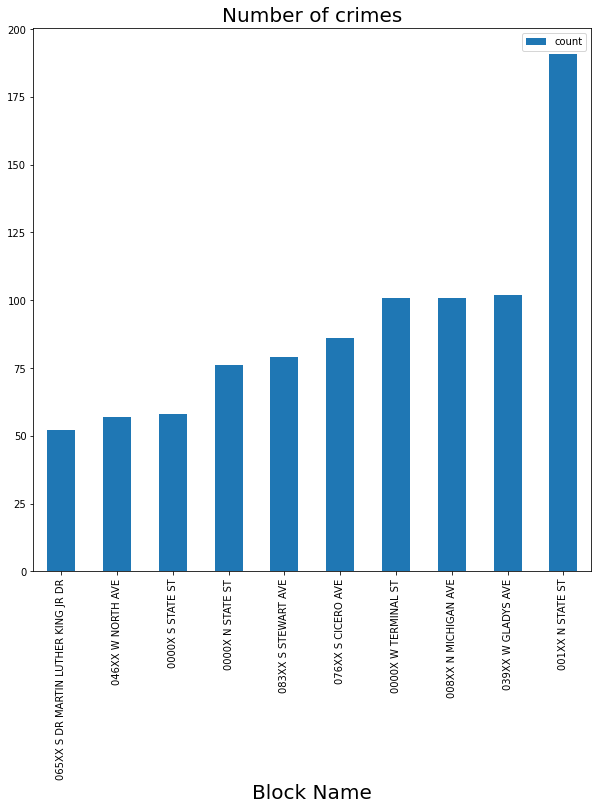

In [ ]:
dataset.groupBy("Block")\
        .count().sort('count', ascending=False).limit(10)\
        .toPandas().sort_values(by='count')\
        .plot(x='Block',y='count',\
         sort_columns=True,kind='bar', \
         figsize=(10, 10),fontsize=10)
plt.title("Number of crimes", fontsize=20)
plt.xlabel('Block Name', fontsize=20)

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

latitude = 41.864073157
longitude = -87.706818608


heatMap = folium.Map(location=[latitude, longitude], 
                 tiles = "OpenStreetMap",
                zoom_start=12)
hotspot = dataset.toPandas().head(20000)
heat_data = [[row['Latitude'],row['Longitude']] for index, row in hotspot.iterrows()]
HeatMap(heat_data, radius=10).add_to(heatMap)

heatMap

In [ ]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", \
                            "Longitude"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100,impurity='gini', maxBins=128)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)
predictions.select("predictedLabel", "Primary Type").show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)


print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

predictions.groupBy("predictedLabel").count().show()

+--------------+--------------------+
|predictedLabel|        Primary Type|
+--------------+--------------------+
|       BATTERY|     CRIMINAL DAMAGE|
|       BATTERY|       OTHER OFFENSE|
|       BATTERY|PUBLIC PEACE VIOL...|
|       BATTERY|             BATTERY|
|     NARCOTICS|               THEFT|
|       BATTERY|               THEFT|
|       BATTERY|               THEFT|
|         THEFT|             ROBBERY|
|       BATTERY|             BATTERY|
|       BATTERY|             ROBBERY|
|         THEFT|             BATTERY|
|       BATTERY|           NARCOTICS|
|         THEFT|   CRIMINAL TRESPASS|
|       BATTERY|             BATTERY|
|       BATTERY|             BATTERY|
|         THEFT|             BATTERY|
|       BATTERY|     CRIMINAL DAMAGE|
|         THEFT|         SEX OFFENSE|
|     NARCOTICS|             BATTERY|
|         THEFT|PUBLIC PEACE VIOL...|
+--------------+--------------------+
only showing top 20 rows

accuracy = 0.267348
f1 score = 0.175788
+--------------+-----+